<a href="https://colab.research.google.com/github/Yquetzal/Teaching_notebooks/blob/main/Networks/cours_HAL_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import io
import collections
from itertools import combinations
import networkx as nx
pd.options.display.max_colwidth = 100
import seaborn as sns
from matplotlib import pyplot as plt

# Introduction
HAL est la plateforme de dépôt qui centralise de nombreuses informations sur la recherche française: tous les chercheurs sont censé y déposer les références de leurs publications, et l'on peut également y trouver des informations sur les institutions, affiliation des chercheurs, etc.

HAL propose un site web permettant de faire des recherches manuellement https://hal.archives-ouvertes.fr , mais aussi une API permettant de faire des requêtes à partir de code informatique.

Cette API a une documentation assez sommaire, mais nous allons voir comment obtenir un ensemble d'informations de bases sur des publications, puis comment traiter ces informations à l'aide de python pour créer une visualization sous forme de graphes.
La page principale de la documentation se trouve ici:
https://api.archives-ouvertes.fr/docs/search

Mais d'autres références utiles proposent des exemples de requêtes qui peuvent vous aider à obtenir ce que vous cherchez, notamment:
* https://wiki.ccsd.cnrs.fr/wikis/hal/index.php/API:Recherche:Hal
* https://api.archives-ouvertes.fr/docs/ref/?resource=structure&schema=fields
* https://www.slideshare.net/OAccsd/usage-des-api-de-hal

# Requete: les bases
En utilisant python, il suffit d'une ligne pour faire une requête à l'API. Une requête est une url (que l'on peut donc entrer aussi dans un navigateur comme n'importe quelle adresse web), qui décrit ce que l'on souhaite obtenir.

Le début de l'url correspond à l'adresse de l'API de HAL et sera toujours la même: `http://api.archives-ouvertes.fr`.
Pour faire des recherches sur des articles, on va ajouter `/search/` à la suite (ce serait différent pour chercher des informations sur les auteurs ou les structures, par exemple).

Pour indiquer ce que l'on souhaite chercher, on va enfin rajouter le mot-clef `?q=MOT` où MOT est le mot qui nous intéresse. Par exemple, pour chercher mes publications, on pourra écrire:
`http://api.archives-ouvertes.fr/search/?q=cazabet`

Le nombre de réponses que l'on souhaite recevoir est indiqué avec l'option `rows=X`. Par défaut, X=30, et la valeur maximale est 10 000. Au delà, il faut utiliser un système un peu plus complexe, expliqué plus tard.

In [ ]:
# On fait la requête et l'on met le resultat dans la variable "response"
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&rows=3")

#On affiche le résultat. Par défaut, le résultat est en json. Pour chaque article, une citation standard est fournie.
response.json()

{'response': {'numFound': 25,
  'start': 0,
  'docs': [{'docid': 2016671,
    'label_s': 'Rémi Vaudaine, Christine Largeron, Rémy Cazabet. Network properties captured by graph embeddings. Complex Network, 2018, Cambridge, United Kingdom. &#x27E8;hal-02016671&#x27E9;',
    'uri_s': 'https://hal.archives-ouvertes.fr/hal-02016671'},
   {'docid': 2456857,
    'label_s': 'Rémi Vaudaine, Christine Largeron, Rémy Cazabet. Comparing the preservation of network properties by graph embeddings. Eighteenth International Symposium on Intelligent Data Analysis (IDA 2020), Apr 2020, Bodenseeforum, Germany. &#x27E8;hal-02456857&#x27E9;',
    'uri_s': 'https://hal.archives-ouvertes.fr/hal-02456857'},
   {'docid': 1500352,
    'label_s': "Rémy Cazabet, Pierre Borgnat, Pablo Jensen. Using Degree Constrained Gravity Null-Models to understand the structure of journeys' networks in Bicycle Sharing Systems. ESANN 2017 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine 

# Requête: données détaillées
Afin d'analyser les publications en détails, un résultat sous la forme d'un seul champ de texte n'est pas très pratique. Il est possible de préciser les données que l'on souhaite obtenir avec l'option:
`fl=champ1,champ2,...,champX`.
A ma connaissance, l'ensemble des champs possible n'est pas détaillé clairement dans l'API, et un très grand nombre de champs existent. Ci-dessous, j'ai dressé une liste des champs qui m'ont semblé les plus utiles:
* `title_s`: Titre de l'article
* `authFullName_s`: Nom complet des auteurs
* `keyword_s`: Mots-clefs de l'article (lorsque disponible)
* `publicationDate_s`: Date de publication
* `publisher_s`: Éditeur
* `docType_s`: Type de publication (conférence, article de journal, chapitre de livre, thèse...)

* `structName_s`: Nom des structures auxquelles les auteurs appartiennent (attention, il y a fréquemment plusieurs structures par auteur)
* `structCountry_s`: Pour chaque structure, le pays duquel il dépend
* `structType_s`: Pour chaque strucutre, son type (laboratoire, université, regroupement d'université...)
* `structAddress_s`: Pour chaque structure, son addresse
* `structHasAuthId_fs`: Champ permettant de faire le lien entre les auteurs et les (multiples) structures.

* `journalTitle_s`: Titre du journal (si c'est un journal, sinon vide)
* `conferenceTitle_s`: Titre de la conférence (si c'est une conférence, sinon vide)


In [ ]:
#Par exemple, si nous nous intéressons au titre des publications, aux affiliations des auteurs et 
#à l'année de publication:
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&rows=2&fl=title_s,keyword_s,publicationDate_s,structName_s")
response.json()

{'response': {'numFound': 25,
  'start': 0,
  'docs': [{'title_s': ['Network properties captured by graph embeddings'],
    'structName_s': ['Laboratoire Hubert Curien [Saint Etienne]',
     'Université Jean Monnet [Saint-Étienne]',
     'Centre National de la Recherche Scientifique',
     "Institut d'Optique Graduate School",
     'Université de Lyon'],
    'publicationDate_s': '2018'},
   {'title_s': ['Comparing the preservation of network properties by graph embeddings'],
    'structName_s': ['Laboratoire Hubert Curien [Saint Etienne]',
     "Institut d'Optique Graduate School",
     'Université Jean Monnet [Saint-Étienne]',
     'Centre National de la Recherche Scientifique'],
    'publicationDate_s': '2020-04-27'}]}}

## Résultats en csv et pandas
Pour que le résultat soit plus lisible, on peut demander les résultats en .csv et les afficher avec pandas avec les
commandes suivantes (notez l'ajout de l'option `wt=csv` pour spécifier le format. Voir https://api.archives-ouvertes.fr/docs/search pour les autres formats possible.)

In [ ]:
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&wt=csv&rows=6&fl=title_s,publicationDate_s,keyword_s,structName_s")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,publicationDate_s,keyword_s,structName_s
0,Network properties captured by graph embeddings,2018,NaN,"Laboratoire Hubert Curien [Saint Etienne],Université Jean Monnet [Saint-Étienne],Centre National..."
1,Comparing the preservation of network properties by graph embeddings,2020-04-27,NaN,"Laboratoire Hubert Curien [Saint Etienne],Institut d'Optique Graduate School,Université Jean Mon..."
2,Using Degree Constrained Gravity Null-Models to understand the structure of journeys' networks i...,2017-04,NaN,"ComplexNetworks,Laboratoire d'Informatique de Paris 6,Université Pierre et Marie Curie - Paris 6..."
3,Enhancing Space-Aware Community Detection Using Degree Constrained Spatial Null Model,2017-03,NaN,"ComplexNetworks,Laboratoire d'Informatique de Paris 6,Université Pierre et Marie Curie - Paris 6..."
4,Tracking the Evolution of Temporal Patterns of Usage in Bicycle-Sharing Systems Using Nonnegativ...,2017,NaN,"ComplexNetworks,Laboratoire d'Informatique de Paris 6,Université Pierre et Marie Curie - Paris 6..."
5,"Détection de communautés dynamiques dans des réseaux temporels,Detection of dynamic communities ...",2013-03-26,"Détection de communautés,Grands graphes,Grands réseaux,Réseaux dynamiques,Communautés dynamiques...",National Institute of Informatics


# Critères de recherche avancés
Les critères de recherche peuvent être complexifiés : on peut imposer d'avoir plusieurs mots avec le mots-clef `AND`, avoir un mot ou un autre (`OR`), utiliser des jokers pour une lettre (`?`), pour un nombre quelconque de lettres (`*`), etc. 
La recherche peut être faite dans un champ particulier tel qu le titre ou les auteurs en précisant le champ sous la forme `Champ:requête`.
La façon d'effectuer ces requêtes avancées est bien décrite avec des exemples dans la documentation: https://api.archives-ouvertes.fr/docs/search

In [ ]:
#Par exemple, cherchons les articles écris par un auteur dont le nom est cazabet et qui contiennent 
#un mot commençant par commu (commu*) dans le titre, ce qui permettra de récupérer à la fois 
# community, communities, communautés, etc.
response = requests.get("http://api.archives-ouvertes.fr/search/?q=title_t:commu* AND authFullName_t:cazabet&wt=csv&fl=title_s,authFullName_s")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,authFullName_s
0,"Détection de communautés dynamiques dans des réseaux temporels,Detection of dynamic communities ...",Rémy Cazabet
1,Characterising Inter and Intra-Community Interactions in Link Streams Using Temporal Motifs,"Jean Creusefond,Rémy Cazabet"
2,Community Discovery in Dynamic Networks: a Survey,"Giulio Rossetti,Rémy Cazabet"
3,Challenges in Community Discovery on Temporal Networks,"Rémy Cazabet,Giulio Rossetti"
4,Enhancing Space-Aware Community Detection Using Degree Constrained Spatial Null Model,"Rémy Cazabet,Pierre Borgnat,Pablo Jensen"
5,Evaluating Community Detection Algorithms for Progressively Evolving Graphs,"Rémy Cazabet,Souâad Boudebza,Giulio Rossetti"
6,"CDLIB: a python library to extract\, compare and evaluate communities from complex networks","Giulio Rossetti,Letizia Milli,Rémy Cazabet"
7,Tracking bitcoin users activity using community detection on a network of weak signals,"Rémy Cazabet,Rim Baccour,Matthieu Latapy"
8,Dynamic Community Detection,"Rémy Cazabet,Giulio Rossetti,Fredéric Amblard"
9,OLCPM: An Online Framework for Detecting Overlapping Communities in Dynamic Social Networks,"Souâad Boudebza,Rémy Cazabet,Faiçal Azouaou,Omar Nouali"


# Tri par date
Une autre option de tri intéressante permet de chercher sur des intervalles de temps. On utilisera dans ce cas l'option `fq=champ_date:[debut TO fin]`, par exemple `fq=publicationDate_s:[2018 TO 2020]` pour se limiter aux articles publiés sur la période de 2018 à 2020. Se reporter à la documentation pour plus de détails. 

In [ ]:
response = requests.get("http://api.archives-ouvertes.fr/search/?q=authFullName_t:cazabet&fq=publicationDate_s:[2018 TO 2020]&wt=csv&fl=title_s,authFullName_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,authFullName_s,publicationDateY_i
0,Community Discovery in Dynamic Networks: a Survey,"Giulio Rossetti,Rémy Cazabet",2018
1,Challenges in Community Discovery on Temporal Networks,"Rémy Cazabet,Giulio Rossetti",2019
2,Network properties captured by graph embeddings,"Rémi Vaudaine,Christine Largeron,Rémy Cazabet",2018
3,Systematic Biases in Link Prediction: comparing heuristic and graph embedding based methods,"Aakash Sinha,Rémy Cazabet,Rémi Vaudaine",2018
4,Temporal Pattern Mining for E-commerce Dataset,"Mohamad Kanaan,Rémy Cazabet,Hamamache Kheddouci",2020
5,"CDLIB: a python library to extract\, compare and evaluate communities from complex networks","Giulio Rossetti,Letizia Milli,Rémy Cazabet",2019
6,OLCPM: An Online Framework for Detecting Overlapping Communities in Dynamic Social Networks,"Souâad Boudebza,Rémy Cazabet,Faiçal Azouaou,Omar Nouali",2018
7,Detecting Stable Communities in Link Streams at Multiple Temporal Scales,"Souâad Boudebza,Rémy Cazabet,Omar Nouali,Faiçal Azouaou",2019


# Restriction à des sous-domaines de HAL
L'un des intérêts de HAL est qu'il est organisé en sous-domaines: chaque université ou laboratoire, par exemple, peut se créer un sous-domaine, et seules les publications des chercheurs affilié à cette organisation en font partie. Il est possible de restreindre la requête à un sous-domaine particulier en ajoutant à l'URL de recherche, après `search`, le nom du sous-domaine. Par exemple:  `/search/UNIV-LYON/?q=XXX` pour chercher les publications de l'université de Lyon (regroupement d'universités de Lyon St-Etienne), ou `/search/LIRIS/?q=XXX` pour le laboratoire LIRIS (dont je fait partie depuis 2017)

In [ ]:
# Notez que seules mes publications depuis 2017 apparaissent, puisqu'avant cela je ne faisait pas partie de cette
# institution
response = requests.get("http://api.archives-ouvertes.fr/search/LIRIS/?q=cazabet&wt=csv&fl=authFullName_s,structName_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,authFullName_s,structName_s,publicationDateY_i
0,"Rémy Cazabet,Souâad Boudebza,Giulio Rossetti","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2020
1,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2020
2,"Alexandre Millot,Romain Mathonat,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2020
3,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2020
4,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2021
5,"Souâad Boudebza,Rémy Cazabet,Faiçal Azouaou,Omar Nouali","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2018
6,"Souâad Boudebza,Rémy Cazabet,Omar Nouali,Faiçal Azouaou","École Nationale Supérieure d'Informatique [Alger],Data Mining and Machine Learning,Laboratoire d...",2019
7,"Anes Bendimerad,Rémy Cazabet,Marc Plantevit,Céline Robardet","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2017
8,"Mohamad Kanaan,Rémy Cazabet,Hamamache Kheddouci","Graphes\, AlgOrithmes et AppLications,Laboratoire d'InfoRmatique en Image et Systèmes d'informat...",2020
9,Rémy Cazabet,"Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,I...",2021


# Statistiques simples
Bien que ce ne soit pas l'objet de ce cour, on peut noter qu'il est maintenant très facile de faire des statistiques simples sur ces données. Par exemple, le nombre de publication d'un auteur (ou d'une institution) par an, ou la proportion de publications d'un type donné

<AxesSubplot:xlabel='publicationDateY_i', ylabel='Count'>

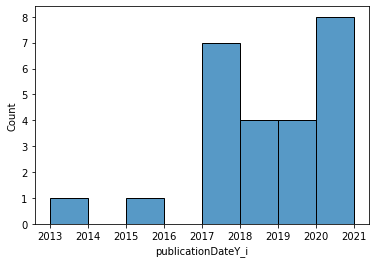

In [ ]:
#NB: ici, les données sont incomplètes pour les premières années. 
#L'incitation aux chercheurs de mettre leurs publications dans HAL date environ de 2017, et est devenue obligatoire
# dans certains cas (financements ANR, Europe...) depuis 2019
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&wt=csv&fl=docType_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")

#en utilisant la librairie seaborn pour faire un histogramme
sns.histplot(as_csv["publicationDateY_i"],binwidth=1)

docType_s
ART       6
COMM     14
COUV      3
DOUV      1
THESE     1
Name: docType_s, dtype: int64


<AxesSubplot:ylabel='docType_s'>

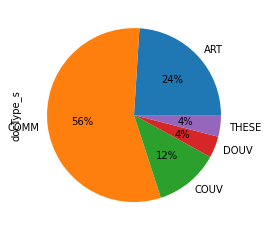

In [ ]:
# En utilisant l'outil graphique de pandas. COMM correspond à des communications dans des conférences, 
#ART à des articles dans des journeaux, COUV: chapitre d'ouvrage, DOUV: direction d'ouvrage
grouped=as_csv.groupby("docType_s")["docType_s"].count()
print(grouped)
grouped.plot.pie(autopct="%.0f%%")

# Grande quantité de données
Comme mentionné précédemment, la quantité d'éléments qui peuvent être retournés par une requête est limité à 10 000. Il est tout à fait possible de faire des requêtes plus importantes, mais il faut dans ce cas utiliser un système de pagination: le résultat est retourné en plusieurs pages qui peuvent être parcourues les unes après les autres.

La méthode la plus simple consiste à demander des résultats triés par identifiants (`&sort=docid asc`), puis de demander de commencer à une certaine ligne avec l'option `&start=num_ligne"`. 

Ainsi, s'il y a 35000 résultats, on peut les obtenirs en demandant les 10 000 premiers, puis ceux de 10000 à 20000, de 20000 à 30000, et enfin de 30000 à 40000.

Il est recommandé d'utiliser plutôt des pages de taille 1000 pour des raisons de performance.

In [ ]:
#Imaginons que l'on souhaite récupérer tous les articles contenant les mots network et graphes.


#On définition la requête de base, sans options
requete="http://api.archives-ouvertes.fr/search/?q=(network AND graph)"



#On écrit une fonction (donc réutilisable) pour récupérer tous les éléments, page par page
def get_all_elements(request_core,page_size=1000):
    df_complet=pd.DataFrame()
    
    #en faisant la requête en json, on peut obtenir le nombre de réponses à récupérer
    nb_reponses=requests.get(request_core).json()["response"]["numFound"]
    print("Nombre d'éléments au total : ",nb_reponses)

    #Cette boucle incrémente le curseur de début, par pas de 1000, jusqu'à atteindre le dernier élément
    for i in range(0,nb_reponses,page_size):
        #On récupére le résultat, en rajoutant des options à la requete de base
        response =requests.get(requete+"&wt=csv&sort=docid asc&start="+str(i)+"&rows="+str(page_size))
        df_temp =pd.read_csv(io.StringIO(response.text),sep=",")

        #On ajoute les réponses les plus récentes à celles que l'on a déjà
        df_complet=df_complet.append(df_temp,ignore_index=True)
        print("Éléments récupérés : ",len(df_complet))
    
    return df_complet #la fonction renvoie le tableau complet

#On appelle la fonction sur notre requete
resultat = get_all_elements(requete)

#Nous pouvons vérifier qu'à la fin, nous avons bien le nombre d'éléments attendus dans notre tableau
resultat

Nombre d'éléments au total :  3254
Éléments récupérés :  1000
Éléments récupérés :  2000
Éléments récupérés :  3000
Éléments récupérés :  3254


,docid,halId_s,version_i,docType_s,citationFull_s,citationRef_s
0,1347,hal-00001347,1,ART,"Christophe Soule. Graphic requirements for multistationarity. <i>Complexus</i>, Karger, 2003, 1,...","<i>Complexus</i>, Karger, 2003, 1, pp.123-133"
1,2834,hal-00002263,1,ART,"Christophe Texier, Pascal Degiovanni. Charge and current distribution in graphs. <i>Journal of P...","<i>Journal of Physics A: Mathematical and Theoretical</i>, IOP Publishing, 2003, 36, pp.12425-12452"
2,27744,hal-00003362,1,ART,Christian Lavault. Embeddings into the Pancake Interconnection Network. <i>Parallel Processing L...,"<i>Parallel Processing Letters</i>, World Scientific Publishing, 2002, 12 (3-4), pp.297-310"
3,28036,hal-00003550,1,COMM,"Jacqueline Vauzeilles, Christophe Fouqueré. Inheritance with exceptions: an attempt at formaliza...","<i>Advances in Linear Logic</i>, 1995, France. pp.167-196"
4,32420,inria-00000158,1,COMM,"Samuel Landau, Olivier Sigaud, Marc Schoenauer. ATNoSFERES revisited. <i>GECCO 2005 - 7th annual...","<i>GECCO 2005 - 7th annual conference on Genetic and Evolutionary Computation Conference, </i>, ..."
...,...,...,...,...,...,...
3249,3315759,hal-03315759,1,UNDEFINED,"Pedro Ramaciotti Morales, Jean-Philippe Cointet, Gabriel Zolotoochin. Unfolding the dimensionali...",2021
3250,3317712,hal-03317712,1,UNDEFINED,"Thomas Messi Nguélé, Jean-François Méhaut. Applying Data Structure Succinctness to Graph Numberi...",2021
3251,3317822,hal-03317822,1,COMM,"Sylvain Lerebourg, Antoine Dutot, Cyrille Bertelle, Damien Olivier. DECISION SUPPORT SYSTEM AND ...","<i>ESS 2003, European Simulation Symposium and Exhibition</i>, Oct 2003, Delft, Netherlands"
3252,3319465,hal-03319465,1,ART,"E. Duviella, A. Doniec, H. Nouasse. Adaptive water-resource allocation planning of inland waterw...","<i>Journal of Water Resources Planning and Management</i>, 2018, 144 (9), <a target=""_blank"" hre..."


# Création d'un réseau de co-auteurs
Imaginons que nous voulons étudier le réseau de co-auteurs (qui travaille avec qui) des chercheurs Lyonnais qui travaillent sur le thème des *networks*, en se limitant aux 10 dernières années. Nous allons procéder en 4 étapes:
1. Récupération des informations qui nous intéressent (articles d'intérêt et leurs auteurs)
2. Pour chaque article avec au moins 2 auteurs, compter un lien entre eux
3. À partir des liens, créer un réseau en utilisant la librairie networkx
4. Exporter le réseau dans un format standard accepté par le logiciel Gephi

In [ ]:
#Notons que nous recherchons dans les résumés, lorsque le mot network est présent mais pas le mot neural, 
#pour éviter d'avoir tous les travaux récent sur les neural networks.
requete = "http://api.archives-ouvertes.fr/search/UNIV-LYON/?q=abstract_t:(network -neural)&fq=publicationDate_s:[2012 TO 2022]&fl=title_s,authFullName_s,abstr*"
co_aut = get_all_elements(requete)

Nombre d'éléments au total :  2180
Éléments récupérés :  1000
Éléments récupérés :  2000
Éléments récupérés :  2180


In [ ]:
collab_list=[]
for authors in list(co_aut["authFullName_s"]): #pour tous les articles
    auth_list=authors.split(",") #on crée une liste des noms d'auteurs
    if len(auth_list) and len(auth_list)<=5: #s'il y a entre 2 et 5 auteurs (pour éviter une explostion de liens)
        for aut1,aut2 in combinations(auth_list,2): #pour chaque paire d'auteurs possible dans la liste
            collab_list.append(frozenset((aut1,aut2))) #on ajoute une collaboration. 
            #noter l'usage du set (frozenset), qui dit qu'il n'y a pas d'ordre entre les éléments: 
            #set((lab1,lab2))==set((lab2,lab1)) alors que [aut1,aut2]!=[aut2,aut1]

#To make the network more insteresting, we also collect the number of articles by author:
author_list=[]
for authors in list(co_aut["authFullName_s"]): #pour tous les articles
    auth_list=authors.split(",") #on crée une liste des noms d'auteurs
    if len(auth_list)<=5:
        for aut in auth_list:
            author_list.append(aut)
        


In [ ]:
#We count how many times each author appears:
nodes=[]
occurences=author_list
for n,occ in dict(collections.Counter(occurences)).items(): #collections.Counter count occurences by item
    if occ>1: #we filter out singleton to keep important actors
        nodes.append((n,{"occurences":occ})) #we store the result in a format convenient for networkx

In [ ]:
#We count how many times each link appears:
edges=[]
occurences=collab_list
for n,occ in dict(collections.Counter(occurences)).items(): #collections.Counter count occurences by item
    if occ>1: #we filter out singleton to keep important relations
        n1,n2=n
        edges.append((n1,n2,{"occurences":occ})) #we store the result in a format convenient for networkx

### Visualisation et export
La dernière étape consite à créer le graphe et à l'exporter.
Après avoir créé l'objet graphe, nous pouvons simplement le visualiser pour vérifier que les données sont bien présentes. Cependant, il est recommandé d'exporter le graphe pour le visualiser avec *Gephi*

In [ ]:
#En utilisant networkx, nous créons un objet graphe
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.remove_nodes_from(list(nx.isolates(g)))

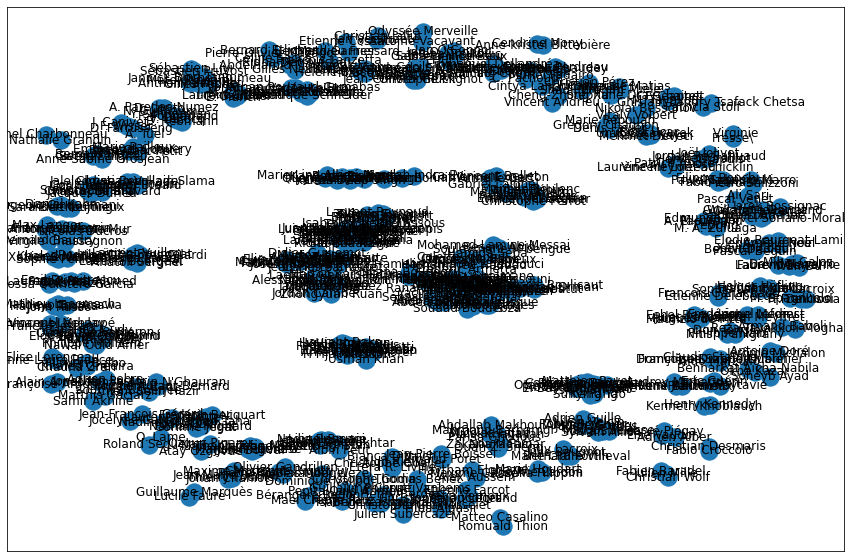

In [ ]:
#Nous le visualisons
plt.figure(1,figsize=(15,10)) 
pos=nx.fruchterman_reingold_layout(g)
nx.draw_networkx(g,pos=pos)

In [ ]:
#Finalement, nous l'exportons au format graphml, qui permet de l'importer immédiatement dans Gephi.
#On peut noter que les attributs (nombre d'occurrences) des nœuds et liens seront accessibles
nx.write_graphml(g,"/Users/remycazabet/Downloads/cocitation.graphml")

# Réseau de relations entre laboratoires
Il est tout à fait possible d'utiliser d'autres informations pour créer d'autres types de réseaux.
Par exemple, en réutilisant exactement la même méthode, nous pouvons créer un réseau de collaborations entre laboratoires.

Les seules différences sont que: 
* Lors de la requête, nous ne nous limitons pas à Lyon, mais à l'ensemble de la France
* Les nœuds correspondent à des laboratoires et non plus à des personnes
* Un lien entre 2 laboratoires représente une collaboration entre 2 personnes de ce laboratoire.

In [ ]:
#au moins un laboratoire français impliqué
requete="http://api.archives-ouvertes.fr/search/?q=abstract_t:(network -neural) AND structCountry_s:fr&fq=publicationDate_s:[2012 TO 2022]&fl=structAcronym_s,structCountry_s,structAddress_s,structType_s,structName_s"

In [ ]:
colab_lab = get_all_elements(requete,5000)

Nombre d'éléments au total :  33263
Éléments récupérés :  5000
Éléments récupérés :  10000
Éléments récupérés :  15000
Éléments récupérés :  20000
Éléments récupérés :  25000
Éléments récupérés :  30000
Éléments récupérés :  33263


In [ ]:
collab_list=[]
struct_names=list(colab_lab["structName_s"])
struct_types=list(colab_lab["structType_s"])
struct_countries=list(colab_lab["structCountry_s"])

all_labs=[]

for i,labs in enumerate(struct_names): 
    current_labs=set()
    names=labs.replace("\\,","_").split(",") # Attention, certains labos ont des virgules dans le nom (\\,)
    types=struct_types[i].split(",")
    countries=struct_countries[i].split(",")
    try: #attention, bug avec quelques labos sans information de pays, on ignore ces lignes
        for j,name in enumerate(names):
            if types[j]=="laboratory" and countries[j]=="fr": #si la strucutre est un labo français
                all_labs.append(name) #on compte un artile pour ce labo
                current_labs.add(name) #on se rappelle qu'il y a ce labo pour créer un lien
    except:
        pass
    if len(current_labs)>=2: #s'il y a au moins 2 labos, on ajoute des liens entre les labos
        for aut1,aut2 in combinations(current_labs,2): 
            collab_list.append(frozenset((aut1,aut2))) 

### Filtrage
Nous faisons des choix (arbitraires dans cet exemple) de filtrage: on ne garde que les laboratoires avec plus de 10 articles et nous considérons un lien robuste à partir de 5 coopérations, pour éviter d'être noyé dans le bruit.

In [ ]:
nodes=[]
occurences=all_labs
for n,occ in dict(collections.Counter(occurences)).items():
    if occ>10: 
        nodes.append((n,{"occurences":occ})) 

In [ ]:
edges=[]
occurences=collab_list
for n,occ in dict(collections.Counter(occurences)).items(): 
    if occ>5: 
        n1,n2=n
        edges.append((n1,n2,{"occurences":occ})) 

In [ ]:
#En utilisant networkx, nous créons un objet graphe
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.remove_nodes_from(list(nx.isolates(g)))

In [ ]:
len(g.edges)

609

In [ ]:

nx.write_graphml(g,"/Users/remycazabet/Downloads/co_labo.graphml")